In [1]:
#import torch
import torchvision
from torchvision import models
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import imghdr
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [2]:
# Ограничитель на cpu
torch.set_num_threads(4)

In [3]:
#fasterrcnn_resnet50_fpn
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
from matplotlib.patches import Rectangle

In [5]:
# Ниже модификация методов
# ДЛЯ РАБОТЫ С ОДИНОКОЙ КАРТИНКОЙ
# Добавлены методы: 
# 1.предсказания наиболее вероятного класса(класса 1 объекта с наибольшей вероятностью)
# 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score

def my_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
        
  
def my_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(10,20))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

## Test block pics

In [ ]:
%%time
torch.set_num_threads(1)
#a = torch.get_num_threads()
my_get_prediction('../projects/data/Positive/112.jpg', threshold=0.1)

In [ ]:
my_get_prediction_class_output('./яхта.jpg', threshold=0.1)

In [ ]:
%%time
my_get_prediction_person_output('./яхта.jpg', threshold=0.1)

In [ ]:
#img_path = './1360291657_dc248c5eea.jpg'
#img_path = './00000105_avatar-Copy1.png'
#img_path = '../projects/17.jpg'
#img_path = './african_crocodile_s_000011-Copy1.png'
#img_path = './people.jpg'
img_path = './shapki/shapka1-1.png'
img = Image.open(img_path)
transform = T.Compose([T.ToTensor()])
img = transform(img)
img = img[0:3]
pred = model([img])
print(pred)

In [ ]:
img.size()

In [ ]:
img

In [ ]:
#my_object_detection_api('./40057579_avatar-Copy1.png', threshold=0.5)
#my_object_detection_api('../projects/data/Positive/112.jpg', threshold=0.1)
#my_object_detection_api('./clusters.png', threshold=0.9)
#my_object_detection_api('./shapki/shapka1-1.png', threshold=0.9)
plt.gca().add_patch(Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='#9b8e7f'))
#rect = Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor= '#9b8e7f')

### NEW Block

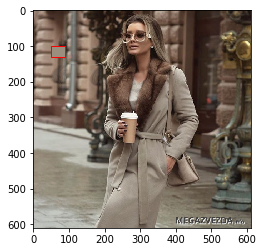

In [94]:
# Display the image
plt.imshow(im)

# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor= '#9b8e7f')

# Add the patch to the Axes
ax.add_patch(rect)

#plt.imshow()

In [ ]:
###Colors try

In [ ]:
q = img.numpy()

In [ ]:
#import scipy

In [ ]:
ar

In [55]:
#im = Image.open('./shapki/shapka1-1.png')
im = Image.open('look.jpg')
#im = Image.open('../../photo_mlife/40057579_avatar-Copy1.png')
#im = Image.open('../../photo_2019-09-03_15-12-33.jpg')
print(im.size)
im = im.resize((150, 150)) 
print(im.size)
ar = np.asarray(im)
ar
shape = ar.shape
shape

(610, 610)
(150, 150)


(150, 150, 3)

In [ ]:
#import imageio
#imageio.imwrite('filename.jpg', array)

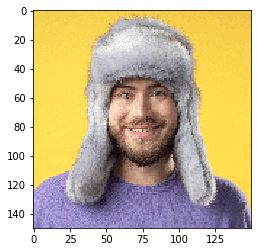

In [79]:
import imageio
#face = misc.face()
#misc.imsave('./shapki/shapka5-2_test.jpg', face) # First we need to create the PNG file
#imageio.imwrite('./shapki/shapka5-2_test.jpg', face)
face = imageio.imread('./output image name.png')
type(face)      

face.shape, face.dtype
plt.imshow(face)

In [54]:
ar

array([[ 13,  13,  13, ...,  13,  57,  13],
       [ 13,  13,  13, ...,  13,  57,  13],
       [ 13,  13,  13, ...,  57,  57,  13],
       ...,
       [ 57,  57,  57, ..., 165,  67,  13],
       [192,  10,  10, ...,  83, 140,  10],
       [ 10,  10,  10, ...,  86,  80, 154]], dtype=uint8)

In [80]:
face_t0 = face[:,:,0:3]

In [69]:
face.shape

(1000, 1000, 4)

In [81]:
face_t0.shape

(150, 150, 3)

In [72]:
face

Array([[[137, 173, 184, 255],
        [139, 165, 175, 255],
        [137, 173, 184, 255],
        ...,
        [140, 181, 189, 255],
        [137, 173, 184, 255],
        [140, 181, 189, 255]],

       [[137, 173, 184, 255],
        [137, 173, 184, 255],
        [137, 173, 184, 255],
        ...,
        [137, 173, 184, 255],
        [137, 173, 184, 255],
        [137, 173, 184, 255]],

       [[137, 173, 184, 255],
        [139, 165, 175, 255],
        [137, 173, 184, 255],
        ...,
        [140, 181, 189, 255],
        [137, 173, 184, 255],
        [140, 181, 189, 255]],

       ...,

       [[140, 181, 189, 255],
        [148, 181, 189, 255],
        [140, 181, 189, 255],
        ...,
        [154, 169, 187, 255],
        [137, 173, 184, 255],
        [140, 181, 189, 255]],

       [[140, 181, 189, 255],
        [140, 181, 189, 255],
        [140, 181, 189, 255],
        ...,
        [156, 181, 191, 255],
        [137, 173, 184, 255],
        [137, 173, 184, 255]],

       [[148

In [71]:
face_t0

Array([[[137, 173, 184],
        [139, 165, 175],
        [137, 173, 184],
        ...,
        [140, 181, 189],
        [137, 173, 184],
        [140, 181, 189]],

       [[137, 173, 184],
        [137, 173, 184],
        [137, 173, 184],
        ...,
        [137, 173, 184],
        [137, 173, 184],
        [137, 173, 184]],

       [[137, 173, 184],
        [139, 165, 175],
        [137, 173, 184],
        ...,
        [140, 181, 189],
        [137, 173, 184],
        [140, 181, 189]],

       ...,

       [[140, 181, 189],
        [148, 181, 189],
        [140, 181, 189],
        ...,
        [154, 169, 187],
        [137, 173, 184],
        [140, 181, 189]],

       [[140, 181, 189],
        [140, 181, 189],
        [140, 181, 189],
        ...,
        [156, 181, 191],
        [137, 173, 184],
        [137, 173, 184]],

       [[148, 181, 189],
        [140, 181, 189],
        [148, 181, 198],
        ...,
        [168, 187, 197],
        [154, 169, 187],
        [140, 181, 189]]

In [77]:
#from PIL import Image
#Resize
img = Image.open('./shapki/shapka10-1.png') # image extension *.png,*.jpg
new_width  = 150
new_height = 150
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('output image name.png') # format may what u want ,*.png,*jpg,*.gif

In [197]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

NUM_CLUSTERS = 5

print('reading image')
im = Image.open('look.jpg')
#im = Image.open('./shapki/shapka1-1.png')
#im = face_t0
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
#print(ar,shape)
#ar = face_t0 
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
print(ar,shape)
print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))
### my block decode all colors
colour_test_list = []
for i in codes:
    colour_test = binascii.hexlify(bytearray(int(c) for c in i)).decode('ascii')
    colour_test_list.append(colour_test)
#colour_test = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')

reading image
[[144. 122. 109.]
 [150. 131. 117.]
 [141. 122. 108.]
 ...
 [113. 105.  94.]
 [121. 113. 102.]
 [123. 115. 104.]] (150, 150, 3)
finding clusters
cluster centres:
 [[ 89.25106816  72.56948118  59.54954222]
 [154.67961333 142.06973934 126.67719662]
 [190.56031946 185.39007987 174.74863388]
 [122.21462545 107.48414586  93.56321839]
 [ 51.47034578  36.90130524  28.59354248]]
most frequent is [154.67961333 142.06973934 126.67719662] (#9a8e7e)


In [198]:
colour_test_list

['59483b', '9a8e7e', 'beb9ae', '7a6b5d', '33241c']

In [75]:
face_t0.shape

(1000, 1000, 3)

In [84]:
colour_test_list

['fbd852', 'ccc3c5', '9a8dae', '7d6970', '44353c']

In [ ]:
# bonus: save image using only the N most common colours
import imageio
c = ar.copy()
for i, code in enumerate(codes):
    c[scipy.r_[scipy.where(vecs==i)],:] = code
imageio.imwrite('clusters.png', c.reshape(*shape).astype(np.uint8))
print('saved clustered image')

In [ ]:
cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)

In [ ]:
len(codes)

In [ ]:
 # pred_boxes, pred_class_num, pred_class, pred_score
  #boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  #img = cv2.imread(img_path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
boxes = len(codes)
if boxes != [0]:
    for i in range(len(codes)):
        cv2.rectangle(img, [0,0], [10,10], color = (0, 255, 0) )#, thickness=rect_th)
        #cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
plt.figure(figsize=(10,20))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
codes

array([[ 52.57114967,  37.87548807,  29.40672451],
       [155.40071429, 142.88517857, 127.47785714],
       [124.26339468, 109.54437628,  95.57157464],
       [190.83077579, 185.69394714, 175.07502131],
       [ 91.33419074,  74.82627622,  61.67985754]])

In [11]:
a = str('#' + colour_test_list[0])
a

'#34251d'

In [85]:
colour_test_list

['fbd852', 'ccc3c5', '9a8dae', '7d6970', '44353c']

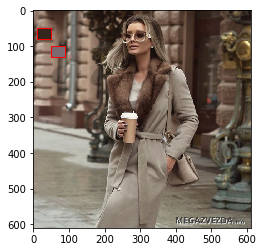

In [88]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

im = Image.open('./look.jpg')

# Display the image
plt.imshow(im)

# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect1 = Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor= '#7d6970')
rect2 = Rectangle((10,50),40,30,linewidth=1,edgecolor='r',facecolor= a)

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

In [ ]:
### Получение цветов шапок

In [189]:
# Resize шапок
img = Image.open('./shapki/shapka7.png') # image extension *.png,*.jpg
new_width  = 300
new_height = 300
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('output image name.png') # format may what u want ,*.png,*jpg,*.gif

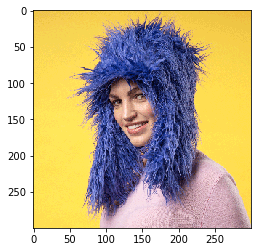

In [181]:
# Считываниеполученных png
import imageio
face = imageio.imread('./output image name.png')
type(face)      

face.shape, face.dtype
plt.imshow(face)

In [182]:
face_t0 = face[:,:,0:3]

In [183]:
face_t0.shape

(300, 300, 3)

reading image
finding clusters
cluster centres:
 [[182.44758381 145.30833053 150.34219083]
 [251.41909411 218.13806334  83.16646611]
 [228.09337036 194.72359135 203.94180261]
 [ 40.47567678  44.34446028  93.9683832 ]
 [ 89.3325033   96.40522924 162.51296323]]
most frequent is [251.41909411 218.13806334  83.16646611] (#fbda53)
the palitra ['b69196', 'fbda53', 'e4c2cb', '282c5d', '5960a2']


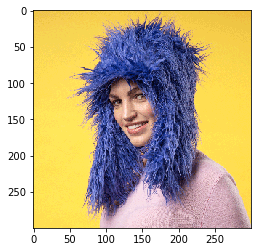

In [184]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

NUM_CLUSTERS = 5

print('reading image')
im = Image.open('look.jpg')
#im = Image.open('./shapki/shapka1-1.png')
#im = face_t0
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
################# My to png shapki start
#shape = ar.shape
shape = face_t0.shape
#print(ar,shape)
ar = face_t0 
############### My to png shapki stop
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
#print(ar,shape)
print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))
### my block decode all colors
colour_test_list = []
for i in codes:
    colour_test = binascii.hexlify(bytearray(int(c) for c in i)).decode('ascii')
    colour_test_list.append(colour_test)
print('the palitra', colour_test_list)
#colour_test = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
plt.imshow(face)

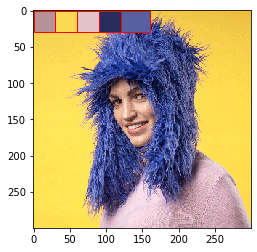

In [185]:
plt.imshow(face)
ax = plt.gca()
x = 0
y = 0
# Create a Rectangle patch
for i in colour_test_list:
    colors = str('#' + i )
    #x += 30
    #y = 100
    rect = Rectangle((x,y),40,30,linewidth=1,edgecolor='r',facecolor = colors)
    ax.add_patch(rect)
    x += 30


# Add the patch to the Axes
#ax.add_patch(rect1)
#ax.add_patch(rect2)

In [169]:
## считаем по-бстырому все цвета шапок

In [191]:
print(pink,gray,red,malina,green,white,blue)

['f4cbdb', 'cc939b'] ['ccc3c5'] ['ed6551', 'a22d2d'] ['9f0858'] ['b2cdb8'] ['eadacd'] ['5960a2']


In [186]:
blue = []
blue.append(colour_test_list[4])
blue

In [205]:
gray_rgb = PIL.ImageColor.getrgb(str('#'+ gray[0]))
malina_rgb = PIL.ImageColor.getrgb(str('#'+ malina[0]))
green_rgb = PIL.ImageColor.getrgb(str('#'+ green[0]))
white_rgb = PIL.ImageColor.getrgb(str('#'+ white[0]))
blue_rgb = PIL.ImageColor.getrgb(str('#'+ blue[0]))

In [239]:
shapka = np.array([gray_rgb,malina_rgb,green_rgb,white_rgb,blue_rgb])
shapka

array([[204, 195, 197],
       [159,   8,  88],
       [178, 205, 184],
       [234, 218, 205],
       [ 89,  96, 162]])

In [ ]:
### нужно добавить отрезание по маске и ее подавать на кластеризацию цветов тут и в луках image.fit()

#### Собственно основное:
#### 1. читаем лук (img, png по -разному)
#### 2. детектим персон и получаем маску или бокс
#### 3. спектрируем полученное в 2
#### 4. находим расстояние от спектра лука до цветов шапок
#### 5. выбираем минимальное

In [337]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

NUM_CLUSTERS = 5

print('reading image')
im = Image.open('images.jpg')
#im = Image.open('./shapki/shapka1-1.png')
#im = face_t0
im = im.resize((150, 150))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
#print(ar,shape)
#ar = face_t0 
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
print(ar,shape)
print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
print('most frequent is %s (#%s)' % (peak, colour))
### my block decode all colors
colour_test_list = []
for i in codes:
    colour_test = binascii.hexlify(bytearray(int(c) for c in i)).decode('ascii')
    colour_test_list.append(colour_test)
#colour_test = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')

reading image
[[173. 172. 168.]
 [173. 172. 168.]
 [173. 172. 168.]
 ...
 [ 83.  73.  71.]
 [ 77.  67.  65.]
 [138. 128. 126.]] (150, 150, 3)
finding clusters
cluster centres:
 [[181.75888985  29.97224631  33.68777103]
 [153.96801075 147.8983871  143.19045699]
 [ 93.26237906  73.60216278  60.57541264]
 [132.7546492  121.26521555 112.00063398]
 [168.74588838 167.02399569 165.81315719]]
most frequent is [153.96801075 147.8983871  143.19045699] (#99938f)


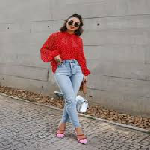

In [338]:
im

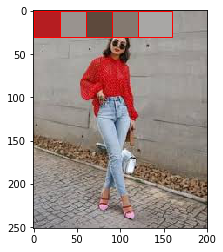

In [339]:
im = Image.open('./images.jpg')
plt.imshow(im)
ax = plt.gca()
x = 0
y = 0
# Create a Rectangle patch
for i in colour_test_list:
    colors = str('#' + i )
    #x += 30
    #y = 100
    rect = Rectangle((x,y),40,30,linewidth=1,edgecolor='r',facecolor = colors)
    ax.add_patch(rect)
    x += 30


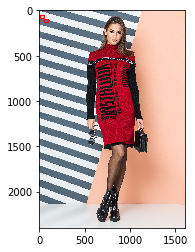

In [335]:
plt.imshow(im)

# Get the current reference
ax = plt.gca()

# Create a Rectangle patch
rect1 = Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor= str('#'+blue[0]))
rect2 = Rectangle((10,50),40,30,linewidth=1,edgecolor='r',facecolor= str('#'+green[0]))

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

In [340]:
look = colour_test_list

In [341]:
look 

['b51d21', '99938f', '5d493c', '847970', 'a8a7a5']

In [342]:
look_colors = []
for i in look:
    look_color = PIL.ImageColor.getrgb(str('#'+ i))
    look_colors.append(look_color)

In [329]:
look_colors

[(249, 204, 184),
 (233, 235, 236),
 (93, 108, 122),
 (98, 19, 33),
 (226, 160, 132)]

In [283]:
d = 2
d**2

4

In [312]:
from math import sqrt
#Эвклидово
def euclidean(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    return sqrt(sum([
        (p1[i] - p2[i]) ** 2 for i in range(len(p1))
    ]))
# Какая-то формула
def some_strange(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    rmean = (p1[0] + p2[0])/2
    r = p1[0] - p2[0]
    g = p1[1] - p2[1]
    b = p1[2] - p2[2]
    return sqrt((2+(rmean/256))*(r**2) + 4*(g**2) + (2+(255-rmean)/256)*(b**2))

In [313]:
euclidean(gray_rgb,look_colors[0])
some_strange(gray_rgb,look_colors[0])

480.5699700290791

In [220]:
a = np.array(gray_rgb)
a
b = np.array(look_colors[0])y576

In [259]:
shapka = np.array([gray_rgb,malina_rgb,green_rgb,white_rgb,blue_rgb])

In [330]:
# Расстояние от всех цветов спектра
j = 0
dist_l = []
for shapka_i in shapka:
    shapka_i = rgb2lab(shapka_i)
    for i in look_colors:
        i = rgb2lab(i)
        dist = some_strange(shapka_i,i)
        dist_l.append(dist)
        j += 1
        if j % 5 == 0:
            #print(j)
            res_shapka = sum(dist_l[-5:])
    print(shapka_i,dist_l[-5:],'\n',res_shapka)

[79.5562, 3.4972, 0.1116] [33.31898316395459, 21.975179968040432, 55.605199360023946, 110.36308997694441, 54.58860063612491] 
 275.8510531050883
[34.4966, 59.259, -3.0934] [123.89296541296429, 148.2200256672851, 124.4681197930956, 57.94623128285131, 104.636691566067] 
 559.1640337222633
[79.9475, -13.0768, 7.4148] [54.61357985068675, 34.70430418366608, 63.47506840973349, 131.4395653353261, 74.95071908794137] 
 359.1832368673538
[87.9893, 3.3521, 8.3606] [23.249022214775433, 18.287895657606366, 72.1999828883521, 119.30338373994621, 50.76497478344492] 
 283.80525928412504
[42.9108, 15.2163, -36.6354] [108.03341791998109, 100.86308495868934, 57.3241603888929, 98.58386774737447, 110.81743360471802] 
 475.62196461965584


In [300]:
shapka

array([[204, 195, 197],
       [159,   8,  88],
       [178, 205, 184],
       [234, 218, 205],
       [ 89,  96, 162]])

In [ ]:
look_most = rgb2lab(look_colors[0])
look_most

In [345]:
look_colors[0]

(181, 29, 33)

In [ ]:
# Расстояние от основного цвета
j = 0
dist_l = []
for shapka_i in shapka:
    shapka_i = rgb2lab(shapka_i)
    dist = euclidean(shapka_i,look_most)
    dist_l.append(dist)
    print(shapka_i,dist_l[-1:],'\n')

In [ ]:
shapka = np.array([gray_rgb,malina_rgb,green_rgb,white_rgb,blue_rgb])

In [319]:
look_colors[3]

(154, 141, 126)

In [321]:
look_most = rgb2lab(look_colors[3])
look_most

[59.3667, 2.2668, 9.7543]

In [317]:
# пространство lab в нем эвклидово расстояние соотвествует воспринимаемой человеком схожести цветов
def rgb2lab ( inputColor ) :

   num = 0
   RGB = [0, 0, 0]

   for value in inputColor :
       value = float(value) / 255

       if value > 0.04045 :
           value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
       else :
           value = value / 12.92

       RGB[num] = value * 100
       num = num + 1

   XYZ = [0, 0, 0,]

   X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
   Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
   Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
   XYZ[ 0 ] = round( X, 4 )
   XYZ[ 1 ] = round( Y, 4 )
   XYZ[ 2 ] = round( Z, 4 )

   XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
   XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
   XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883

   num = 0
   for value in XYZ :

       if value > 0.008856 :
           value = value ** ( 0.3333333333333333 )
       else :
           value = ( 7.787 * value ) + ( 16 / 116 )

       XYZ[num] = value
       num = num + 1

   Lab = [0, 0, 0]

   L = ( 116 * XYZ[ 1 ] ) - 16
   a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
   b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

   Lab [ 0 ] = round( L, 4 )
   Lab [ 1 ] = round( a, 4 )
   Lab [ 2 ] = round( b, 4 )

   return Lab

### Validation from data/face

In [ ]:
import torch
import numpy as np
import imghdr
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


dataset = datasets.ImageFolder('data/face/val/',transform=transform)


test_size = 0.01
valid_size = 1
batch_size = 1

#For test
num_data = len(dataset)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)
classes = [0,1]

In [ ]:
# !!!! ДЛЯ ДАТАСЕТА
# Добавлены методы: 1.предсказания наиболее вероятного класса 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  #img = Image.open(img_path)
  #transform = T.Compose([T.ToTensor()])
  #img = transform(img)
  img = img_path
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score

def my_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
 
def my_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  img = img_path
  #img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [ ]:
### Оценка качества бинарной классификации
def validation_model(threshold = 0.9):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    data_fp = []
    data_fn = []
    Precision = 0.
    Recall = 0.
    Acc = 0.
    i = 0
    
    for data, target in valid_loader:
        pred = my_get_prediction_person_output(data[0], threshold=threshold)
        #print(pred)
        #print(target)
        i += 1
        if i % 20 == 0:
            print('Progress bar:)',i)
        
        if pred == target:
            if pred == 1:
                tp += 1
            else:
                tn += 1
        else:
            if pred == 1:
                fp += 1
                data_fp.append(data[0])
            else:
                fn += 1
                data_fn.append(data[0])
    Precision = tp/(tp+fp)
    print('Precision',Precision)
    Recall = tp/(tp+fn)
    print('Recall',Recall)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    print('Acc',Acc)
    return tp,tn,fp,fn,Acc,Precision,Recall,data_fp,data_fn
        

In [ ]:
%%time
#Валидация
a = validation_model(threshold = 0.95)

## Картиночки и оценки по тесту для HR

In [ ]:
# Data_Loader

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 20
dataset = datasets.ImageFolder('data/test_m/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Data_Loader start

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 20
dataset = datasets.ImageFolder('data/test_m/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

### Data_Loader end

### Картинки от HR: отрисовка и предсказание

pred_list = []

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images_n = images.numpy() # convert images to numpy for display
for i in images:
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(18):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:',labels[idx].item(),'Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
%%time

# Data_Loader
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 1
dataset = datasets.ImageFolder('data/test_m/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

a = validation_model(threshold = 0.95)

### Оценки по Mlife dataset 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Data_Loader start

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 20
dataset = datasets.ImageFolder('data/mlife_photo/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

### Data_Loader end

### Картинки от HR: отрисовка и предсказание

pred_list = []

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images_n = images.numpy() # convert images to numpy for display
for i in images:
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:',labels[idx].item(),'Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
%%time
torch.set_num_threads(4)

# Data_Loader
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 1
dataset = datasets.ImageFolder('data/mlife_photo/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(dataset,batch_size=len(dataset.imgs), num_workers=1)
a = validation_model(threshold = 0.95)

In [ ]:
len(x[8])

In [ ]:
### Картиночки FN

In [ ]:
#### Картиночки FN
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
### Возьмем из результатов list FN(a[8]) и перекинем в тензор
tt2 = torch.cat(a[8], dim = 0)
images_all = tt2.reshape([28,3,224,224])
images = images_all[18:28]
#####   
pred_list = [] 
    
images_n = images.numpy() # convert images to numpy for display
for i in images:
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(28, 4))
# display 20 images
#for idx in np.arange(28):
for idx in range(len(images_n)):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:1','Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
#my_get_prediction(images[13],threshold=0.1)
my_get_prediction(images[9],threshold=0.1)
#my_get_prediction_class_output(images,threshold=0.95)
#my_get_prediction_person_output(images,threshold=0.95)

In [ ]:
pred = model(images)
print(pred)

In [ ]:
#x

In [ ]:
#tt = torch.cat([x[0],x[1]], dim = 0)

### Модификация на более жесткие требования

In [ ]:
# !!!! ДЛЯ ДАТАСЕТА
# Добавлены методы: 1.предсказания наиболее вероятного класса 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  #img = Image.open(img_path)
  #transform = T.Compose([T.ToTensor()])
  #img = transform(img)
  img = img_path
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score


def my_get_prediction_person_tough(img_path, threshold, threshold_hum):
    ###
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    output = []
    # Кол-во уникальных классов для отсчения зашумленных картинок
    for class_num in pred_class_num:
        if class_num not in output:
            output.append(class_num)
    ### Person
    person = 0
    indx_list = []
    indx_list = [i for i, x in enumerate(pred_class_num) if x == 1] 
    for indx in indx_list:
        if pred_score[indx] > threshold_hum:
            person += 1
    
    if (len(output) < 5) and (person > 0) :
        prediction = 1
    else:
        prediction = 0
        
    return prediction

def my_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
 
def my_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  img = img_path
  #img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [ ]:
### Оценка качества бинарной классификации
def validation_model(threshold = 0.2, threshold_hum = 0.95 ):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    data_fp = []
    data_fn = []
    Precision = 0.
    Recall = 0.
    Acc = 0.
    i = 0
    
    for data, target in valid_loader:
        pred = my_get_prediction_person_tough(data[0], threshold=threshold, threshold_hum = threshold_hum)
        #print(pred)
        #print(target)
        i += 1
        if i % 20 == 0:
            print('Progress bar:)',i,tp,tn,fp,fn)
        
        if pred == target:
            if pred == 1:
                tp += 1
            else:
                tn += 1
        else:
            if pred == 1:
                fp += 1
                data_fp.append(data[0])
            else:
                fn += 1
                data_fn.append(data[0])
    Precision = tp/(tp+fp)
    print('Precision',Precision)
    Recall = tp/(tp+fn)
    print('Recall',Recall)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    print('Acc',Acc)
    return tp,tn,fp,fn,Acc,Precision,Recall,data_fp,data_fn
        

In [ ]:
%%time
torch.set_num_threads(6)

# Data_Loader
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 1
dataset = datasets.ImageFolder('data/mlife_photo/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(dataset,batch_size=len(dataset.imgs), num_workers=1)
a = validation_model(threshold = 0.2, threshold_hum = 0.95 )
#print(a)

In [ ]:
#### Картиночки FN по консервативному алгоритму
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
### Возьмем из результатов list FN(a[8]) и перекинем в тензор
tt2 = torch.cat(a[8], dim = 0)
images_all = tt2.reshape([len(a[8]),3,224,224])
### Посмотрим k- результатов
k = len(a[8])
#k = 8
images = images_all[0:k]
#####   
pred_list = [] 
    
images_n = images.numpy() # convert images to numpy for display
for i in images:
    # Предсказываем менее консервативным алгоритмом
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
#fig = plt.figure(figsize=(28, 4))
fig = plt.figure(figsize=(56, 8))
# display 20 images
#for idx in np.arange(28):
for idx in range(len(images_n)):
    ax = fig.add_subplot(8, k/8, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:1','Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
#### Картиночки FN
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
### Возьмем из результатов list FN(a[8]) и перекинем в тензор
tt2 = torch.cat(a[8], dim = 0)
images_all = tt2.reshape([len(a[8]),3,224,224])
### Посмотрим k- результатов
k = len(a[8])
#k = 8
images = images_all[0:k]
#####   
pred_list = [] 
    
images_n = images.numpy() # convert images to numpy for display
#for i in images:
    # Предсказываем менее консервативным алгоритмом
    #pred = my_get_prediction_person_output(i, threshold=0.95)
    #pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
#fig = plt.figure(figsize=(28, 4))
fig = plt.figure(figsize=(56, 8))
# display 20 images
#for idx in np.arange(28):
for idx in range(len(images_n)):
    ax = fig.add_subplot(8, k/8, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    #ax.set_title(('Class:1','Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
len(a[8])

In [ ]:
#img_path = './40057579_avatar-Copy1.png'

### Другие модели 

#### Alexnet 

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import imghdr


plt.ion()

In [ ]:
# Инициализация модели

###ALEXNET 2 class CrossEntropyLoss + Softmax
model_alex = torchvision.models.alexnet(pretrained=True)
# create two list for feature and classifier blocks
ft_list = list(model_alex.features)
cl_list = list(model_alex.classifier)

# Modifing feature block after removing the last max-pool layer (ft_list[12])
model_alex.features = nn.Sequential(ft_list[0], ft_list[1], ft_list[2],
                                  ft_list[3], ft_list[4], ft_list[5],
                                  ft_list[6], ft_list[7], ft_list[8],
                                  ft_list[9], ft_list[10], ft_list[11], ft_list[12])


# Modifing classifier block with a dropout and a fc layer only
cl_list[1] = nn.Linear(9216, 1000)
cl_list[2] = nn.Linear(1000, 2)
model_alex.classifier = nn.Sequential(cl_list[0], cl_list[1], cl_list[2],nn.Softmax() )
#model_alex = model_alex.to(device)


In [ ]:
# Подгрузка весов

import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
# load model cnn!
#model_alex = Net()
###ALEXNET 2 class CrossEntropyLoss + Softmax
model_alex = torchvision.models.alexnet(pretrained=True)
# create two list for feature and classifier blocks
ft_list = list(model_alex.features)
cl_list = list(model_alex.classifier)

# Modifing feature block after removing the last max-pool layer (ft_list[12])
model_alex.features = nn.Sequential(ft_list[0], ft_list[1], ft_list[2],
                                  ft_list[3], ft_list[4], ft_list[5],
                                  ft_list[6], ft_list[7], ft_list[8],
                                  ft_list[9], ft_list[10], ft_list[11], ft_list[12])


# Modifing classifier block with a dropout and a fc layer only
cl_list[1] = nn.Linear(9216, 1000)
cl_list[2] = nn.Linear(1000, 2)
model_alex.classifier = nn.Sequential(cl_list[0], cl_list[1], cl_list[2],nn.Softmax() )
#model_alex = model_alex.to(device)
model_alex.load_state_dict(torch.load('model_alexnet.pt'))
model_alex.eval()
model_alex.state_dict()

#### MRCNN

In [ ]:
#maskrcnn_resnet50_fpn
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
my_get_prediction('./images.jpg', threshold=0.1)

In [ ]:
my_get_prediction_class_output('./images.jpg', threshold=0.1)

In [ ]:
my_get_prediction_person_output('./images.jpg', threshold=0.1)

In [ ]:
#my_object_detection_api('./images.jpg', threshold=0.1)

#### Keypoint R-CNN

In [ ]:
#torchvision.models.detection.keypointrcnn_resnet50_fpn
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COCO_PERSON_KEYPOINT_NAMES = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle'
]

In [ ]:
# Ниже модификация методов
# ДЛЯ РАБОТЫ С ОДИНОКОЙ КАРТИНКОЙ
# Добавлены методы: 
# 1.предсказания наиболее вероятного класса(класса 1 объекта с наибольшей вероятностью)
# 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_face_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_PERSON_KEYPOINT_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score

def my_face_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_face_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
        
  
def my_face_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_face_get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
my_face_get_prediction('./images.jpg', threshold=0.1)

In [ ]:
my_face_object_detection_api('./images.jpg', threshold=0.1)